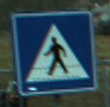

In [2]:
from PIL import Image
path = "../BelgiumTS/Training/00056/00303_00000.ppm"
path = "../BelgiumTS/Training/00056/00297_00002.ppm"
path = "../BelgiumTS/Training/00056/01200_00000.ppm"
display(Image.open(path))

In [ ]:
import os
rootdir = '/home/jzornig/devel/BelgiumTS/Training/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        print(os.path.join(subdir, file))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
#model = models.vgg19(pretrained=True)
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Init BayesianOptimization

In [ ]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

In [ ]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'max_epoch', 'type': 'discrete', 'domain': (1, 60)},
        {'name': 'stepsize', 'type': 'discrete', 'domain': (20, 40)},
        {'name': 'batchsize', 'type': 'discrete', 'domain': (10, 100)}]
#lr 0.0003 --max-epoch 60 --stepsize 20 40 --train-batch 32 --test-batch 100

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

In [6]:
for param in model.parameters():
    #param.requires_grad = True # VGG19
    param.requires_grad = False # ResNet50
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 #nn.Linear(512, 62),
                                 nn.Linear(512, 80),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [7]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
                
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'HelloPyTorch.pth')

Epoch 1/1.. Train loss: 3.468.. Test loss: 2.800.. Test accuracy: 0.411
Epoch 1/1.. Train loss: 2.471.. Test loss: 2.206.. Test accuracy: 0.486
Epoch 1/1.. Train loss: 1.736.. Test loss: 1.634.. Test accuracy: 0.609
Epoch 1/1.. Train loss: 1.487.. Test loss: 1.382.. Test accuracy: 0.635
Epoch 1/1.. Train loss: 1.365.. Test loss: 1.160.. Test accuracy: 0.715


In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
## save 
torch.save(model.state_dict(), "./HelloPyTorch_resnet50_weights.pt")

In [ ]:
from ax import *

resnet_search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="learning_rate", parameter_type=ParameterType.FLOAT, lower=0, upper=1
        ),
        RangeParameter(
            name="max_epoch", parameter_type=ParameterType.INTEGER, lower=1, upper=30
        ),
        RangeParameter(
            name="stepsize", parameter_type=ParameterType.INTEGER, lower=20, upper=40
        ),
        RangeParameter(
            name="batchsize", parameter_type=ParameterType.INTEGER, lower=10, upper=100
        ),
    ]
)

exp = SimpleExperiment(
    name="test_branin",
    search_space=resnet_search_space,
    evaluation_function=lambda p: branin(p["x1"], p["x2"]),
    objective_name="branin",
    minimize=True,
)

sobol = Models.SOBOL(exp.search_space)
for i in range(5):
    exp.new_trial(generator_run=sobol.gen(1))

best_arm = None
for i in range(15):
    gpei = Models.GPEI(experiment=exp, data=exp.eval())
    generator_run = gpei.gen(1)
    best_arm, _ = generator_run.best_arm_predictions
    exp.new_trial(generator_run=generator_run)

best_parameters = best_arm.parameters

# Optimize a Torch Model with Ax

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate

init_notebook_plotting()

PyTorch Version:  1.1.0
Torchvision Version:  0.2.2


[INFO 05-19 23:27:19] ipy_plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [2]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_dir = '/home/jzornig/devel/BelgiumTS/Training/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((57,57)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((57,57)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
#trainloader, testloader = load_split_train_test(data_dir, .2)
#print(trainloader.dataset.classes)
#print(len(trainloader.dataset.classes))

In [4]:
train_loader, valid_loader = load_split_train_test(data_dir, .2)

In [31]:
net


CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1280, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
def train_evaluate(parameterization):
    #net = train(train_loader=train_loader, parameters=parameterization, dtype=dtype, device=device)
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
    #param.requires_grad = True # VGG19
        param.requires_grad = False # ResNet50
    
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 #nn.Linear(512, 62),
                                 nn.Linear(512, 80),
                                 nn.LogSoftmax(dim=1))
    #criterion = nn.NLLLoss()
    #optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
    return evaluate(
        net=model,
        data_loader=train_loader,
        dtype=dtype,
        device=device,
    )

In [11]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        #{"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
        {"name": "max_epoch", "type": "range", "bounds": [1, 30]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},
        {"name": "batchsize", "type": "range", "bounds": [10, 100]},
        
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

[INFO 05-20 06:41:20] ax.service.utils.dispatch: Using Bayesian Optimization generation strategy. Iterations after 5 will take longer to generate due to model-fitting.
[INFO 05-20 06:41:20] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 05-20 06:41:20] ax.service.managed_loop: Running optimization trial 1...
[INFO 05-20 06:41:56] ax.service.managed_loop: Running optimization trial 2...
[INFO 05-20 06:42:34] ax.service.managed_loop: Running optimization trial 3...
[INFO 05-20 06:43:09] ax.service.managed_loop: Running optimization trial 4...
[INFO 05-20 06:43:45] ax.service.managed_loop: Running optimization trial 5...
[INFO 05-20 06:44:24] ax.service.managed_loop: Running optimization trial 6...
[INFO 05-20 06:45:06] ax.service.managed_loop: Running optimization trial 7...
[INFO 05-20 06:45:45] ax.service.managed_loop: Running optimization trial 8...
[INFO 05-20 06:46:27] ax.service.managed_loop: Running optimization trial 9...
[INFO 05-20 06:47:06] ax.service.

In [12]:
best_parameters

{'lr': 0.0015118706900009594, 'max_epoch': 2, 'stepsize': 40, 'batchsize': 35}

In [13]:
means, covariances = values
means, covariances

({'accuracy': 0.07049180089915703},
 {'accuracy': {'accuracy': 8.80289009602516e-12}})

In [20]:
render(plot_contour(model=model, param_x='lr', param_y='momentum', metric_name='accuracy'))

In [21]:
# `plot_single_method` expects a 2-d array of means, because it expects to average means from multiple 
# optimization runs, so we wrap out best objectives array in another array.
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

In [22]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='12_0', parameters={'lr': 0.00020134470130439496, 'momentum': 0.26958900203179714})

In [23]:
net = train(
    train_loader=train_loader, 
    parameters=best_arm.parameters,
    dtype=dtype,
    device=device,
)
test_accuracy = evaluate(
    net=net,
    data_loader=test_loader,
    dtype=dtype,
    device=device,
)

In [24]:
print(f"Classification Accuracy (test set): {round(test_accuracy*100, 2)}%")

Classification Accuracy (test set): 92.22%
